In [154]:
import csv 
import sqlite3

In [155]:
data_path='/Users/saisatvikhlakkimsetty/Downloads/ev_charging_patterns.csv'

In [156]:
conn=sqlite3.connect('prac.db')
ev_cursor=conn.cursor()

In [157]:
"""CODE"""

'CODE'

In [158]:
# Connect to SQLite database
conn = sqlite3.connect('prac.db')
ev_cursor = conn.cursor()

# Drop existing tables (if any)
drop_queries = [
    "DROP TABLE IF EXISTS Users;",
    "DROP TABLE IF EXISTS ChargingStations;",
    "DROP TABLE IF EXISTS ChargingSessions;",
    "DROP TABLE IF EXISTS EnvironmentalData;"
]

for query in drop_queries:
    ev_cursor.execute(query)
    conn.commit()

# Create Users Table
create_users_table = """
CREATE TABLE Users (
    user_id VARCHAR(50) PRIMARY KEY,
    user_type VARCHAR(50),
    vehicle_model VARCHAR(50),
    vehicle_age_years FLOAT
);
"""
ev_cursor.execute(create_users_table)
conn.commit()
print("Users table created successfully.")

# Create ChargingStations Table
create_station_table = """
CREATE TABLE ChargingStations (
    station_id VARCHAR(50) PRIMARY KEY,
    station_location VARCHAR(100),
    charger_type VARCHAR(50)
);
"""
ev_cursor.execute(create_station_table)
conn.commit()
print("ChargingStations table created successfully.")

# Create ChargingSessions Table (with foreign keys)
create_sessions_table = """
CREATE TABLE ChargingSessions (
    session_id INTEGER PRIMARY KEY AUTOINCREMENT,
    user_id VARCHAR(50),
    station_id VARCHAR(50),
    start_time TIMESTAMP,
    end_time TIMESTAMP,
    duration_hours FLOAT,
    energy_consumed_kwh FLOAT,
    charging_cost_usd FLOAT,
    charging_rate_kw FLOAT,
    soc_start_percent FLOAT,
    soc_end_percent FLOAT,
    time_of_day VARCHAR(50),
    day_of_week VARCHAR(50),
    FOREIGN KEY(user_id) REFERENCES Users(user_id),
    FOREIGN KEY(station_id) REFERENCES ChargingStations(station_id)
);
"""
ev_cursor.execute(create_sessions_table)
conn.commit()
print("ChargingSessions table created successfully.")

# Create EnvironmentalData Table (with foreign key)
create_env_data_table = """
CREATE TABLE EnvironmentalData (
    session_id INTEGER,
    distance_driven_km FLOAT,
    temperature_c FLOAT,
    battery_capacity_kwh FLOAT,
    PRIMARY KEY(session_id),
    FOREIGN KEY(session_id) REFERENCES ChargingSessions(session_id)
);
"""
ev_cursor.execute(create_env_data_table)
conn.commit()
print("EnvironmentalData table created successfully.")

# Close connection
conn.close()


Users table created successfully.
ChargingStations table created successfully.
ChargingSessions table created successfully.
EnvironmentalData table created successfully.


In [159]:
import csv
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('ev_charging.db')
ev_cursor = conn.cursor()

# CSV path
data_path = '/Users/saisatvikhlakkimsetty/Downloads/ev_charging_patterns.csv'

# Queries for data insertion
insert_user_query = """
INSERT OR IGNORE INTO Users (user_id, user_type, vehicle_model, vehicle_age_years)
VALUES (?, ?, ?, ?);
"""

insert_station_query = """
INSERT OR IGNORE INTO ChargingStations (station_id, station_location, charger_type)
VALUES (?, ?, ?);
"""

insert_sessions_query = """
INSERT INTO ChargingSessions (user_id, station_id, start_time, end_time, duration_hours, 
                             energy_consumed_kwh, charging_cost_usd, charging_rate_kw, 
                             soc_start_percent, soc_end_percent, time_of_day, day_of_week)
VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
"""

insert_env_data_query = """
INSERT INTO EnvironmentalData (session_id, distance_driven_km, temperature_c, battery_capacity_kwh)
VALUES (?, ?, ?, ?);
"""

# Open CSV and insert data
with open(data_path, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        try:
            # Insert user data (ignores if already exists)
            ev_cursor.execute(insert_user_query, (
                row['User ID'],
                row['User Type'],
                row['Vehicle Model'],
                row['Vehicle Age (years)']
            ))

            # Insert station data (ignores if already exists)
            ev_cursor.execute(insert_station_query, (
                row['Charging Station ID'],
                row['Charging Station Location'],
                row['Charger Type']
            ))

            # Insert session data
            ev_cursor.execute(insert_sessions_query, (
                row['User ID'],  # user_id
                row['Charging Station ID'],  # station_id
                row['Charging Start Time'],
                row['Charging End Time'],
                row['Charging Duration (hours)'],
                row['Energy Consumed (kWh)'],
                row['Charging Cost (USD)'],
                row['Charging Rate (kW)'],
                row['State of Charge (Start %)'],
                row['State of Charge (End %)'],
                row['Time of Day'],
                row['Day of Week']
            ))

            # Insert environmental data
            # Assuming session_id matches the session for which environmental data is provided
            ev_cursor.execute(insert_env_data_query, (
                row['Charging Start Time'],  # This should be the session_id or its equivalent
                row['Distance Driven (since last charge) (km)'],
                row['Temperature (°C)'],
                row['Battery Capacity (kWh)']
            ))

            # Commit changes to the database
            conn.commit()
        except sqlite3.IntegrityError as e:
            print(f"Integrity error: {e}")
        except Exception as e:
            print(f"Error: {e}")

# Close connection
conn.close()


In [160]:
import pandas as pd
import sqlite3

# Connect to SQLite database
conn = sqlite3.connect('ev_charging.db')

# SQL query to join the tables and combine data
select_data_from_tables = """
SELECT 
    u.user_id,
    u.user_type,
    u.vehicle_model,
    u.vehicle_age_years,
    cs.station_id,
    cs.station_location,
    cs.charger_type,
    s.start_time,
    s.end_time,
    s.duration_hours,
    s.energy_consumed_kwh,
    s.charging_cost_usd,
    s.charging_rate_kw,
    s.soc_start_percent,
    s.soc_end_percent,
    s.time_of_day,
    s.day_of_week,
    e.distance_driven_km,
    e.temperature_c,
    e.battery_capacity_kwh
FROM Users u
JOIN ChargingSessions s ON u.user_id = s.user_id
JOIN ChargingStations cs ON s.station_id = cs.station_id
JOIN EnvironmentalData e ON s.session_id = e.session_id;
"""

# Execute query and load the data into a DataFrame
df = pd.read_sql_query(select_data_from_tables, conn)

# Display the DataFrame
print(df)

# Close the connection
conn.close()


        user_id               user_type vehicle_model  vehicle_age_years  \
0        User_1                Commuter        BMW i3                2.0   
1        User_2           Casual Driver  Hyundai Kona                3.0   
2        User_3                Commuter    Chevy Bolt                2.0   
3        User_4  Long-Distance Traveler  Hyundai Kona                1.0   
4        User_5  Long-Distance Traveler  Hyundai Kona                1.0   
...         ...                     ...           ...                ...   
1315  User_1316                Commuter   Nissan Leaf                7.0   
1316  User_1317           Casual Driver        BMW i3                4.0   
1317  User_1318                Commuter   Nissan Leaf                5.0   
1318  User_1319                Commuter    Chevy Bolt                5.0   
1319  User_1320                Commuter   Nissan Leaf                5.0   

       station_id station_location     charger_type           start_time  \
0     Stati

In [161]:
df.head()

user_id               user_type vehicle_model  vehicle_age_years  \
0  User_1                Commuter        BMW i3                2.0   
1  User_2           Casual Driver  Hyundai Kona                3.0   
2  User_3                Commuter    Chevy Bolt                2.0   
3  User_4  Long-Distance Traveler  Hyundai Kona                1.0   
4  User_5  Long-Distance Traveler  Hyundai Kona                1.0   

    station_id station_location     charger_type           start_time  \
0  Station_391          Houston  DC Fast Charger  2024-01-01 00:00:00   
1  Station_428    San Francisco          Level 1  2024-01-01 01:00:00   
2  Station_181    San Francisco          Level 2  2024-01-01 02:00:00   
3  Station_327          Houston          Level 1  2024-01-01 03:00:00   
4  Station_108      Los Angeles          Level 1  2024-01-01 04:00:00   

              end_time  duration_hours energy_consumed_kwh  charging_cost_usd  \
0  2024-01-01 00:39:00        0.591363           60.712346          13.087717   
1  2024-01-01 03:01:00        3.133652           12.339275          21.128448   
2  2024-01-01 04:48:00        2.452653           19.128876          35.667270   
3  2024-01-01 06:42:00        1.266431           79.457824          13.036239   
4  2024-01-01 05:46:00        2.019765           19.629104          10.161471   

  charging_rate_kw  soc_start_percent  soc_end_percent time_of_day  \
0        36.389181          29.371576        86.119962     Evening   
1        30.677735          10.115778        84.664344     Morning   
2        27.513593           6.854604        69.917615     Morning   
3         32.88287          83.120003        99.624328     Evening   
4        10.215712          54.258950        63.743786     Morning   

  day_of_week distance_driven_km  temperature_c  battery_capacity_kwh  
0     Tuesday         293.602111      27.947953            108.463007  
1      Monday         112.112804      14.311026            100.000000  
2    Thursday          71.799253      21.002002             75.000000  
3    Saturday         199.577785      38.316313             50.000000  
4    Saturday         203.661847      -7.834199             50.000000

In [162]:
df.dropna(inplace=True)

In [163]:
df.isna().sum()

user_id                 0
user_type               0
vehicle_model           0
vehicle_age_years       0
station_id              0
station_location        0
charger_type            0
start_time              0
end_time                0
duration_hours          0
energy_consumed_kwh     0
charging_cost_usd       0
charging_rate_kw        0
soc_start_percent       0
soc_end_percent         0
time_of_day             0
day_of_week             0
distance_driven_km      0
temperature_c           0
battery_capacity_kwh    0
dtype: int64

In [164]:
%pip install scikit-learn
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [165]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [166]:
X = df.drop(columns=['user_type'])
y = df['user_type']

In [167]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=None, random_state=42
)

In [168]:
user_type_distribution = df['user_type'].value_counts(normalize=True)
print("Original dataset 'User Type' distribution:")
print(user_type_distribution)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['user_type'], random_state=42)

train_distribution = train_df['user_type'].value_counts(normalize=True)
test_distribution = test_df['user_type'].value_counts(normalize=True)

print("\nTrain set 'User Type' distribution:")
print(train_distribution)

print("\nTest set 'User Type' distribution:")
print(test_distribution)

Original dataset 'User Type' distribution:
user_type
Commuter                  0.360606
Long-Distance Traveler    0.331061
Casual Driver             0.308333
Name: proportion, dtype: float64

Train set 'User Type' distribution:
user_type
Commuter                  0.360795
Long-Distance Traveler    0.331439
Casual Driver             0.307765
Name: proportion, dtype: float64

Test set 'User Type' distribution:
user_type
Commuter                  0.359848
Long-Distance Traveler    0.329545
Casual Driver             0.310606
Name: proportion, dtype: float64


In [169]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [170]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Data Profile Report", explorative=True)
profile.to_file("ev_charging_patterns_profile_report.html")

profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [171]:
"""
Observations:

1. Missing Values
The dataset contains 66 missing values, which accounts for approximately 0.3% of the data.
Missing values are present in the following columns: 'Energy Consumed (kWh)','Charging Rate (kW)','Distance Driven (since last charge) (km)'

2. Duplicates
A thorough check reveals that there are no duplicate rows in the dataset, indicating data uniqueness.

3. Categorical Variables
The dataset includes the following categorical variables:
'User Type': Represents the type of user which is our traget ariable
'Vehicle Model': Indicates the vehicle model being used.
'Charger Type': Specifies the type of charger employed during the session.
'Charging Station Location': Describes the location of the charging station.
All these variables have low cardinality (each contains between 3 and 5 unique values), making them manageable for encoding or analysis.

4. Numerical Variables
Some inconsistencies and unusual patterns were identified:
'State of Charge (Start %)' and 'State of Charge (End %)':
Both columns have values exceeding 100%, which is logically inconsistent and requires correction or capping.

'Temperature (°C)':
The recorded temperatures range from -10.72°C to 73.17°C, suggesting potential outliers that need further investigation.

Strong correlations observed:
'Energy Consumed (kWh)' and 'Charging Duration (hours)' have a strong positive correlation (0.95).
'Battery Capacity (kWh)' and 'Charging Rate (kW)' show a moderate positive correlation (0.68).

5. Date/Time Variables

The dataset includes two datetime variables: 'Charging Start Time','Charging End Time'
These variables can be leveraged to derive new features like charging duration, time of day, or day of the week.

6. Distributions

Some numerical features show distinct patterns: 'Charging Duration (hours)' and 'Charging Cost (USD)':
Both exhibit right-skewed distributions, indicating a few sessions with unusually high values.

"""

"\nObservations:\n\n1. Missing Values\nThe dataset contains 66 missing values, which accounts for approximately 0.3% of the data.\nMissing values are present in the following columns: 'Energy Consumed (kWh)','Charging Rate (kW)','Distance Driven (since last charge) (km)'\n\n2. Duplicates\nA thorough check reveals that there are no duplicate rows in the dataset, indicating data uniqueness.\n\n3. Categorical Variables\nThe dataset includes the following categorical variables:\n'User Type': Represents the type of user which is our traget ariable\n'Vehicle Model': Indicates the vehicle model being used.\n'Charger Type': Specifies the type of charger employed during the session.\n'Charging Station Location': Describes the location of the charging station.\nAll these variables have low cardinality (each contains between 3 and 5 unique values), making them manageable for encoding or analysis.\n\n4. Numerical Variables\nSome inconsistencies and unusual patterns were identified:\n'State of Char

In [172]:
df.head()

user_id               user_type vehicle_model  vehicle_age_years  \
0  User_1                Commuter        BMW i3                2.0   
1  User_2           Casual Driver  Hyundai Kona                3.0   
2  User_3                Commuter    Chevy Bolt                2.0   
3  User_4  Long-Distance Traveler  Hyundai Kona                1.0   
4  User_5  Long-Distance Traveler  Hyundai Kona                1.0   

    station_id station_location     charger_type           start_time  \
0  Station_391          Houston  DC Fast Charger  2024-01-01 00:00:00   
1  Station_428    San Francisco          Level 1  2024-01-01 01:00:00   
2  Station_181    San Francisco          Level 2  2024-01-01 02:00:00   
3  Station_327          Houston          Level 1  2024-01-01 03:00:00   
4  Station_108      Los Angeles          Level 1  2024-01-01 04:00:00   

              end_time  duration_hours energy_consumed_kwh  charging_cost_usd  \
0  2024-01-01 00:39:00        0.591363           60.712346          13.087717   
1  2024-01-01 03:01:00        3.133652           12.339275          21.128448   
2  2024-01-01 04:48:00        2.452653           19.128876          35.667270   
3  2024-01-01 06:42:00        1.266431           79.457824          13.036239   
4  2024-01-01 05:46:00        2.019765           19.629104          10.161471   

  charging_rate_kw  soc_start_percent  soc_end_percent time_of_day  \
0        36.389181          29.371576        86.119962     Evening   
1        30.677735          10.115778        84.664344     Morning   
2        27.513593           6.854604        69.917615     Morning   
3         32.88287          83.120003        99.624328     Evening   
4        10.215712          54.258950        63.743786     Morning   

  day_of_week distance_driven_km  temperature_c  battery_capacity_kwh  
0     Tuesday         293.602111      27.947953            108.463007  
1      Monday         112.112804      14.311026            100.000000  
2    Thursday          71.799253      21.002002             75.000000  
3    Saturday         199.577785      38.316313             50.000000  
4    Saturday         203.661847      -7.834199             50.000000

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   user_id               1320 non-null   object 
 1   user_type             1320 non-null   object 
 2   vehicle_model         1320 non-null   object 
 3   vehicle_age_years     1320 non-null   float64
 4   station_id            1320 non-null   object 
 5   station_location      1320 non-null   object 
 6   charger_type          1320 non-null   object 
 7   start_time            1320 non-null   object 
 8   end_time              1320 non-null   object 
 9   duration_hours        1320 non-null   float64
 10  energy_consumed_kwh   1320 non-null   object 
 11  charging_cost_usd     1320 non-null   float64
 12  charging_rate_kw      1320 non-null   object 
 13  soc_start_percent     1320 non-null   float64
 14  soc_end_percent       1320 non-null   float64
 15  time_of_day          

In [174]:
df.describe()

vehicle_age_years  duration_hours  charging_cost_usd  \
count        1320.000000     1320.000000        1320.000000   
mean            3.612843        2.269377          22.551352   
std             2.309824        1.061037          10.751494   
min             0.000000        0.095314           0.234317   
25%             2.000000        1.397623          13.368141   
50%             4.000000        2.258136          22.076360   
75%             6.000000        3.112806          31.646044   
max            11.688592        7.635145          69.407743   

       soc_start_percent  soc_end_percent  temperature_c  battery_capacity_kwh  
count        1320.000000      1320.000000    1320.000000           1320.000000  
mean           49.130012        75.141590      15.263591             74.534692  
std            24.074134        17.080580      14.831216             20.626914  
min             2.325959         7.604224     -10.724770              1.532807  
25%            27.786903        62.053266       2.800664             62.000000  
50%            48.241771        75.682496      14.630846             75.000000  
75%            69.277921        88.201370      27.981810             85.000000  
max           152.489761       177.708666      73.169588            193.003074

In [175]:
df.dtypes

user_id                  object
user_type                object
vehicle_model            object
vehicle_age_years       float64
station_id               object
station_location         object
charger_type             object
start_time               object
end_time                 object
duration_hours          float64
energy_consumed_kwh      object
charging_cost_usd       float64
charging_rate_kw         object
soc_start_percent       float64
soc_end_percent         float64
time_of_day              object
day_of_week              object
distance_driven_km       object
temperature_c           float64
battery_capacity_kwh    float64
dtype: object

In [176]:
df.duplicated().sum()

np.int64(0)

In [177]:
df.isna().sum()

user_id                 0
user_type               0
vehicle_model           0
vehicle_age_years       0
station_id              0
station_location        0
charger_type            0
start_time              0
end_time                0
duration_hours          0
energy_consumed_kwh     0
charging_cost_usd       0
charging_rate_kw        0
soc_start_percent       0
soc_end_percent         0
time_of_day             0
day_of_week             0
distance_driven_km      0
temperature_c           0
battery_capacity_kwh    0
dtype: int64

In [178]:
df.dropna(subset=['vehicle_model','duration_hours','end_time'], inplace=True)

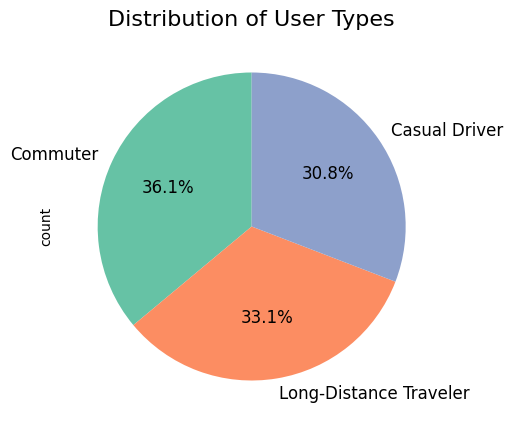

In [179]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Pie chart for the distribution of user types
plt.figure(figsize=(8, 5))
pie_plot = df['user_type'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    startangle=90, 
    colors=sns.color_palette('Set2'),
    fontsize=12
)
plt.title('Distribution of User Types', fontsize=16)
plt.show()


In [180]:
pip install -q dagshub mlflow

Note: you may need to restart the kernel to use updated packages.


In [181]:
"""
Experiment 1
"""

'\nExperiment 1\n'

In [182]:
import dagshub
dagshub.init(repo_owner='saisatvikh', repo_name='final_repo', mlflow=True)

Initialized MLflow to track repo "saisatvikh/final_repo"

Repository saisatvikh/final_repo initialized!

In [183]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
# from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score

In [184]:
categorical_features = X.select_dtypes(include=['object']).columns
for col in categorical_features:
    X[col] = X[col].astype(str)
    
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns

In [185]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
    ('scaler', StandardScaler()) 
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) 
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

In [186]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [187]:
cv_results = cross_val_score(model_pipeline, X_train, y_train, cv=10, scoring='f1_macro')
print(f"Cross-validation F1-score (mean): {cv_results.mean():.4f}")
print(f"Cross-validation F1-score (std): {cv_results.std():.4f}")

Cross-validation F1-score (mean): 0.3352
Cross-validation F1-score (std): 0.0357


In [188]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['vehicle_age_years', 'duration_hours', 'charging_cost_usd',
       'soc_start_percent', 'soc_end_percent', 'temperature_c',
       'battery_capacity_kwh'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['user_id', 'vehicle_model', 'station_id', 'station_location',
       'charger_type', 'start_time', 'end_time', 'energy_consumed_kwh',
       'charging_rate_kw', 'time_of_day', 'day_of_week', 'distance_driven_km'],
      dtype='object'))])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [189]:
y_pred = model_pipeline.predict(X_test)
logistic_f1_score= f1_score(y_test, y_pred,average='macro')
print(f"F1-score on test data: {f1:.4f}")

F1-score on test data: 0.3121


In [190]:
cm = confusion_matrix(y_test, y_pred)
tp = cm.diagonal()
tn = cm.sum(axis=1) - tp
fp = cm.sum(axis=0) - tp
fn = cm.sum() - (tp + fp + tn)

In [191]:
import mlflow
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

with mlflow.start_run(nested=True):
    # Log model and scaler as parameters
    mlflow.log_param("model", "Logistic Regression")
    mlflow.log_param("scaler", "StandardScaler")
  
    # Cross-validation to compute the mean and std of f1 score
    cv_results = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='f1_macro')
    
    mlflow.log_metric("cv_f1_mean", cv_results.mean())
    mlflow.log_metric("cv_f1_std", cv_results.std())
    
    # Train the model
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    # Compute F1 score (macro average)
    f1 = f1_score(y_test, y_pred, average='macro')
    mlflow.log_metric("f1_test", f1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Choose a single class (e.g., class 0)
    class_index = 0  # Change this to select a different class if needed

    # Extract metrics for the selected class
    tp = cm[class_index, class_index]  # True Positive: Diagonal element for the class
    fn = cm[class_index].sum() - tp  # False Negative: Sum of row - TP
    fp = cm[:, class_index].sum() - tp  # False Positive: Sum of column - TP
    tn = cm.sum() - (tp + fn + fp)  # True Negative: Total sum - (TP + FN + FP)

    # Log the metrics for the selected class (e.g., class 0)
    mlflow.log_metric(f"TP_class_{class_index}", tp)
    mlflow.log_metric(f"TN_class_{class_index}", tn)
    mlflow.log_metric(f"FP_class_{class_index}", fp)
    mlflow.log_metric(f"FN_class_{class_index}", fn)

    # Log the model
    mlflow.sklearn.log_model(model_pipeline, "logistic_regression_model")

    # Print the logged metrics for the selected class
    print(f"Logged F1 score to MLFlow: {f1:.4f}")
    print(f"Logged CV results (mean): {cv_results.mean():.4f}")
    print(f"Logged CV results (std): {cv_results.std():.4f}")
    
    # Optionally, print the confusion matrix values for the selected class
    print(f"Confusion Matrix:\n{cm}")
    print(f"True Positives (Class {class_index}): {tp}")
    print(f"True Negatives (Class {class_index}): {tn}")
    print(f"False Positives (Class {class_index}): {fp}")
    print(f"False Negatives (Class {class_index}): {fn}")


2024/12/20 12:30:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged F1 score to MLFlow: 0.3418
Logged CV results (mean): 0.3180
Logged CV results (std): 0.0250
Confusion Matrix:
[[35 46 37]
 [37 65 41]
 [45 52 38]]
True Positives (Class 0): 35
True Negatives (Class 0): 196
False Positives (Class 0): 82
False Negatives (Class 0): 83
🏃 View run popular-roo-825 at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0/runs/9e6bf17b74b84185999f3a6c165f45e7
🧪 View experiment at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0


In [192]:
"""Ridge Classifier"""

'Ridge Classifier'

In [193]:
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')), 
#     ('scaler', StandardScaler()) 
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore')) 
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RidgeClassifier())
])

In [194]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['vehicle_age_years', 'duration_hours', 'charging_cost_usd',
       'soc_start_percent', 'soc_end_percent', 'temperature_c',
       'battery_capacity_kwh'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['user_id', 'vehicle_model', 'station_id', 'station_location',
       'charger_type', 'start_time', 'end_time', 'energy_consumed_kwh',
       'charging_rate_kw', 'time_of_day', 'day_of_week', 'distance_driven_km'],
      dtype='object'))])),
                ('classifier', RidgeClassifier())])

In [195]:
y_pred = model_pipeline.predict(X_test)
ridge_f1_score= f1_score(y_test, y_pred,average='macro')
print(f"F1-score on test data: {f1:.4f}")

F1-score on test data: 0.3418


In [196]:
import mlflow
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

with mlflow.start_run(nested=True):
    # Log model and scaler as parameters
    mlflow.log_param("model", "Ridge Classifier")
    mlflow.log_param("scaler", "StandardScaler")
  
    cv_results = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='f1_macro')
    
    mlflow.log_metric("cv_f1_mean", cv_results.mean())
    mlflow.log_metric("cv_f1_std", cv_results.std())
    
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    f1 = f1_score(y_test, y_pred, average='macro')
    mlflow.log_metric("f1_test", f1)

    cm = confusion_matrix(y_test, y_pred)
    class_index = 0  

    tp = cm[class_index, class_index] 
    fn = cm[class_index].sum() - tp  
    fp = cm[:, class_index].sum() - tp  
    tn = cm.sum() - (tp + fn + fp)  

    mlflow.log_metric(f"TP_class_{class_index}", tp)
    mlflow.log_metric(f"TN_class_{class_index}", tn)
    mlflow.log_metric(f"FP_class_{class_index}", fp)
    mlflow.log_metric(f"FN_class_{class_index}", fn)

    mlflow.sklearn.log_model(model_pipeline, "ridge_model")

    print(f"Logged F1 score to MLFlow: {f1:.4f}")
    print(f"Logged CV results (mean): {cv_results.mean():.4f}")
    print(f"Logged CV results (std): {cv_results.std():.4f}")
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"True Positives (Class {class_index}): {tp}")
    print(f"True Negatives (Class {class_index}): {tn}")
    print(f"False Positives (Class {class_index}): {fp}")
    print(f"False Negatives (Class {class_index}): {fn}")


2024/12/20 12:30:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged F1 score to MLFlow: 0.3432
Logged CV results (mean): 0.3149
Logged CV results (std): 0.0223
Confusion Matrix:
[[37 46 35]
 [37 63 43]
 [45 52 38]]
True Positives (Class 0): 37
True Negatives (Class 0): 196
False Positives (Class 0): 82
False Negatives (Class 0): 81
🏃 View run magnificent-goat-462 at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0/runs/437c5ce49d4549eea1f5976b0879b3f0
🧪 View experiment at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0


In [197]:
"""Random Forest Classifier"""

'Random Forest Classifier'

In [198]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [199]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['vehicle_age_years', 'duration_hours', 'charging_cost_usd',
       'soc_start_percent', 'soc_end_percent', 'temperature_c',
       'battery_capacity_kwh'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['user_id', 'vehicle_model', 'station_id', 'station_location',
       'charger_type', 'start_time', 'end_time', 'energy_consumed_kwh',
       'charging_rate_kw', 'time_of_day', 'day_of_week', 'distance_driven_km'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [200]:
y_pred = model_pipeline.predict(X_test)
random_forest_f1= f1_score(y_test, y_pred,average='macro')
print(f"F1-score on test data: {f1:.4f}")

F1-score on test data: 0.3432


In [201]:
import mlflow
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

with mlflow.start_run(nested=True):
    # Log model and scaler as parameters
    mlflow.log_param("model", "Random Forest Classifier")
    mlflow.log_param("scaler", "StandardScaler")
  
    # Cross-validation to compute the mean and std of f1 score
    cv_results = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='f1_macro')
    
    mlflow.log_metric("cv_f1_mean", cv_results.mean())
    mlflow.log_metric("cv_f1_std", cv_results.std())
    
    # Train the model
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    # Compute F1 score (macro average)
    f1 = f1_score(y_test, y_pred, average='macro')
    mlflow.log_metric("f1_test", f1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Choose a single class (e.g., class 0)
    class_index = 0  # Change this to select a different class if needed

    # Extract metrics for the selected class
    tp = cm[class_index, class_index]  # True Positive: Diagonal element for the class
    fn = cm[class_index].sum() - tp  # False Negative: Sum of row - TP
    fp = cm[:, class_index].sum() - tp  # False Positive: Sum of column - TP
    tn = cm.sum() - (tp + fn + fp)  # True Negative: Total sum - (TP + FN + FP)

    # Log the metrics for the selected class (e.g., class 0)
    mlflow.log_metric(f"TP_class_{class_index}", tp)
    mlflow.log_metric(f"TN_class_{class_index}", tn)
    mlflow.log_metric(f"FP_class_{class_index}", fp)
    mlflow.log_metric(f"FN_class_{class_index}", fn)

    # Log the model
    mlflow.sklearn.log_model(model_pipeline, "random_forest_model")

    # Print the logged metrics for the selected class
    print(f"Logged F1 score to MLFlow: {f1:.4f}")
    print(f"Logged CV results (mean): {cv_results.mean():.4f}")
    print(f"Logged CV results (std): {cv_results.std():.4f}")
    
    # Optionally, print the confusion matrix values for the selected class
    print(f"Confusion Matrix:\n{cm}")
    print(f"True Positives (Class {class_index}): {tp}")
    print(f"True Negatives (Class {class_index}): {tn}")
    print(f"False Positives (Class {class_index}): {fp}")
    print(f"False Negatives (Class {class_index}): {fn}")

2024/12/20 12:31:11 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged F1 score to MLFlow: 0.2715
Logged CV results (mean): 0.3154
Logged CV results (std): 0.0119
Confusion Matrix:
[[  8  81  29]
 [ 15 107  21]
 [ 16  97  22]]
True Positives (Class 0): 8
True Negatives (Class 0): 247
False Positives (Class 0): 31
False Negatives (Class 0): 110
🏃 View run smiling-doe-528 at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0/runs/7126c3e0f6e444b8af46d090c0f4a5b2
🧪 View experiment at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0


In [202]:
import mlflow
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
import numpy as np

with mlflow.start_run(nested=True):
    mlflow.log_param("model", "SVM Classifier")
    mlflow.log_param("scaler", "StandardScaler")
  
    cv_results = cross_val_score(model_pipeline, X_train, y_train, cv=3, scoring='f1_macro')
    
    mlflow.log_metric("cv_f1_mean", cv_results.mean())
    mlflow.log_metric("cv_f1_std", cv_results.std())
    
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)

    svm_f1_score= f1_score(y_test, y_pred, average='macro')
    mlflow.log_metric("f1_test", f1)

    cm = confusion_matrix(y_test, y_pred)

    class_index = 0   

    tp = cm[class_index, class_index] 
    fn = cm[class_index].sum() - tp  
    fp = cm[:, class_index].sum() - tp  
    tn = cm.sum() - (tp + fn + fp)  

    mlflow.log_metric(f"TP_class_{class_index}", tp)
    mlflow.log_metric(f"TN_class_{class_index}", tn)
    mlflow.log_metric(f"FP_class_{class_index}", fp)
    mlflow.log_metric(f"FN_class_{class_index}", fn)

    mlflow.sklearn.log_model(model_pipeline, "svm_model")

    print(f"Logged F1 score to MLFlow: {f1:.4f}")
    print(f"Logged CV results (mean): {cv_results.mean():.4f}")
    print(f"Logged CV results (std): {cv_results.std():.4f}")
    
    print(f"Confusion Matrix:\n{cm}")
    print(f"True Positives (Class {class_index}): {tp}")
    print(f"True Negatives (Class {class_index}): {tn}")
    print(f"False Positives (Class {class_index}): {fp}")
    print(f"False Negatives (Class {class_index}): {fn}")

2024/12/20 12:31:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Logged F1 score to MLFlow: 0.2715
Logged CV results (mean): 0.2989
Logged CV results (std): 0.0151
Confusion Matrix:
[[13 75 30]
 [17 98 28]
 [17 85 33]]
True Positives (Class 0): 13
True Negatives (Class 0): 244
False Positives (Class 0): 34
False Negatives (Class 0): 105
🏃 View run carefree-mink-409 at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0/runs/82b9803a998a48de9b13ec099338523f
🧪 View experiment at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0


In [203]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


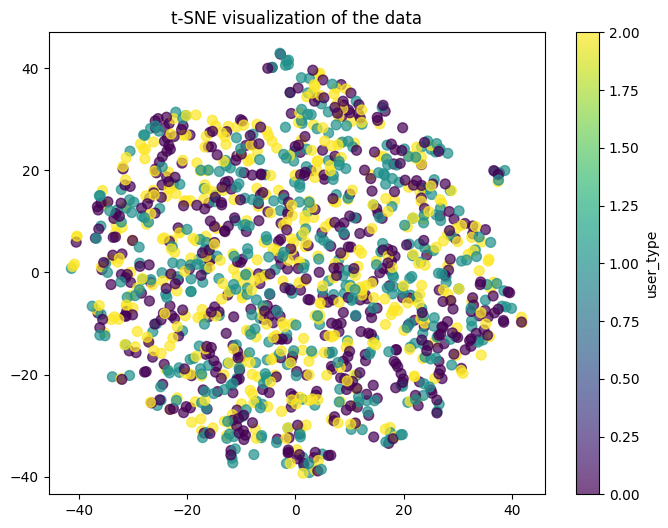

2024/12/20 12:31:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3}
Confusion Matrix:
[[35 19 21]
 [33 28 36]
 [43 30 19]]
Classification Report:
                        precision    recall  f1-score   support

         Casual Driver       0.32      0.47      0.38        75
              Commuter       0.36      0.29      0.32        97
Long-Distance Traveler       0.25      0.21      0.23        92

              accuracy                           0.31       264
             macro avg       0.31      0.32      0.31       264
          weighted avg       0.31      0.31      0.30       264

🏃 View run abrasive-trout-827 at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0/runs/f715a15c01b04a31bd929414eaf453f3
🧪 View experiment at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0


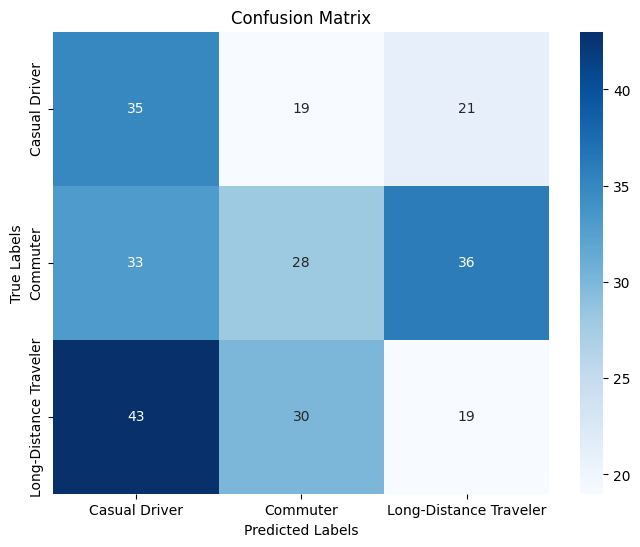

In [204]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

numerical_columns = df.select_dtypes(include=["float64", "int64"]).columns
imputer = SimpleImputer(strategy="median")
df[numerical_columns] = imputer.fit_transform(df[numerical_columns])

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_columns]), columns=numerical_columns)

label_encoder = LabelEncoder()
df['charger_type_encoded'] = label_encoder.fit_transform(df['charger_type'])

tsne = TSNE(n_components=2, random_state=42)
df_tsne = tsne.fit_transform(df_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], c=df['charger_type_encoded'], cmap='viridis', s=50, alpha=0.7)
plt.title('t-SNE visualization of the data')
plt.colorbar(label='user_type')
plt.show()

X = df_scaled
y = df['user_type']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'metric': ['euclidean', 'manhattan'],
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, scoring='accuracy')

with mlflow.start_run():
    mlflow.log_param("cv_folds", 5)
    mlflow.log_param("param_grid", param_grid)

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_knn = grid_search.best_estimator_

    mlflow.log_params(best_params)

    y_pred = best_knn.predict(X_val)

    cm = confusion_matrix(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)
    
    mlflow.log_metric("accuracy", report["accuracy"])
    mlflow.log_metric("macro_avg_f1", report["macro avg"]["f1-score"])
    mlflow.log_metric("weighted_avg_f1", report["weighted avg"]["f1-score"])
    mlflow.log_metric("precision", report["macro avg"]["precision"])
    mlflow.log_metric("recall", report["macro avg"]["recall"])

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    mlflow.sklearn.log_model(best_knn, "knn_model")
    
    print(f"Best Parameters: {best_params}")
    print(f"Confusion Matrix:\n{cm}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")


In [205]:
import pandas as pd
import numpy as np

# Function to ensure numeric columns
def ensure_numeric_columns(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') 
    return df

def add_attribute_combinations(df):
    """Creates new features by combining existing attributes."""
    df = df.copy() 

    numeric_columns = [
        'energy_consumed_kwh', 'duration_hours', 'distance_driven_km', 
        'charging_cost_usd', 'soc_end_percent', 'soc_start_percent', 'temperature_c'
    ]

    df = ensure_numeric_columns(df, numeric_columns)

    # Add new features
    # df['energy_per_duration'] = df['energy_consumed_kwh'] / df['duration_hours']
    # df['distance_per_duration'] = df['distance_driven_km'] / df['duration_hours']
    df['charging_cost_per_kwh'] = df['charging_cost_usd'] / df['energy_consumed_kwh']
    df['soc_diff'] = df['soc_end_percent'] - df['soc_start_percent']
    df['temperature_adjusted_energy'] = df['energy_consumed_kwh'] / (1 + np.abs(df['temperature_c']))

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    
    return df

df_with_features = add_attribute_combinations(df)

print(df_with_features.head())


  user_id               user_type vehicle_model  vehicle_age_years  \
0  User_1                Commuter        BMW i3                2.0   
1  User_2           Casual Driver  Hyundai Kona                3.0   
2  User_3                Commuter    Chevy Bolt                2.0   
3  User_4  Long-Distance Traveler  Hyundai Kona                1.0   
4  User_5  Long-Distance Traveler  Hyundai Kona                1.0   

    station_id station_location     charger_type           start_time  \
0  Station_391          Houston  DC Fast Charger  2024-01-01 00:00:00   
1  Station_428    San Francisco          Level 1  2024-01-01 01:00:00   
2  Station_181    San Francisco          Level 2  2024-01-01 02:00:00   
3  Station_327          Houston          Level 1  2024-01-01 03:00:00   
4  Station_108      Los Angeles          Level 1  2024-01-01 04:00:00   

              end_time  duration_hours  ...  soc_end_percent  time_of_day  \
0  2024-01-01 00:39:00        0.591363  ...        86.119962   

In [206]:
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

# Ensure numeric data is selected
numeric_features = [
    'battery_capacity_kwh', 'charging_cost_usd', 
    'duration_hours', 'soc_end_percent', 'soc_start_percent', 
    'temperature_c', 'vehicle_age_years'
]

# Function to generate polynomial features
def add_polynomial_features(df, numeric_features, degree=2):
    numeric_data = df[numeric_features]
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(numeric_data)
    poly_feature_names = poly.get_feature_names_out(numeric_features)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
    df = pd.concat([df, poly_df], axis=1)
    return df

df_with_poly_features = add_polynomial_features(df, numeric_features, degree=2)
print(df_with_poly_features.head())

  user_id               user_type vehicle_model  vehicle_age_years  \
0  User_1                Commuter        BMW i3                2.0   
1  User_2           Casual Driver  Hyundai Kona                3.0   
2  User_3                Commuter    Chevy Bolt                2.0   
3  User_4  Long-Distance Traveler  Hyundai Kona                1.0   
4  User_5  Long-Distance Traveler  Hyundai Kona                1.0   

    station_id station_location     charger_type           start_time  \
0  Station_391          Houston  DC Fast Charger  2024-01-01 00:00:00   
1  Station_428    San Francisco          Level 1  2024-01-01 01:00:00   
2  Station_181    San Francisco          Level 2  2024-01-01 02:00:00   
3  Station_327          Houston          Level 1  2024-01-01 03:00:00   
4  Station_108      Los Angeles          Level 1  2024-01-01 04:00:00   

              end_time  duration_hours  ... soc_end_percent^2  \
0  2024-01-01 00:39:00        0.591363  ...       7416.647931   
1  2024-01

In [207]:
import mlflow
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures

numeric_features = [
    'battery_capacity_kwh', 'charging_cost_usd', 
    'duration_hours', 'soc_end_percent', 'soc_start_percent', 
    'temperature_c', 'vehicle_age_years'
]

def add_polynomial_features(df, numeric_features, degree=2):
    numeric_data = df[numeric_features]
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly.fit_transform(numeric_data)
    poly_feature_names = poly.get_feature_names_out(numeric_features)
    poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=df.index)
    df = pd.concat([df, poly_df], axis=1)
    return df

df_with_poly_features = add_polynomial_features(df, numeric_features, degree=2)

mlflow.log_param("polynomial_degree", 2)
mlflow.log_param("numeric_features", numeric_features)

mlflow.log_metric("num_poly_features", len(df_with_poly_features.columns) - len(df.columns))

df_with_poly_features.to_csv("polynomial_features_dataset.csv", index=False)
mlflow.log_artifact("polynomial_features_dataset.csv")

print(df_with_poly_features.head())

print("Feature engineering results logged in MLflow.")

  user_id               user_type vehicle_model  vehicle_age_years  \
0  User_1                Commuter        BMW i3                2.0   
1  User_2           Casual Driver  Hyundai Kona                3.0   
2  User_3                Commuter    Chevy Bolt                2.0   
3  User_4  Long-Distance Traveler  Hyundai Kona                1.0   
4  User_5  Long-Distance Traveler  Hyundai Kona                1.0   

    station_id station_location     charger_type           start_time  \
0  Station_391          Houston  DC Fast Charger  2024-01-01 00:00:00   
1  Station_428    San Francisco          Level 1  2024-01-01 01:00:00   
2  Station_181    San Francisco          Level 2  2024-01-01 02:00:00   
3  Station_327          Houston          Level 1  2024-01-01 03:00:00   
4  Station_108      Los Angeles          Level 1  2024-01-01 04:00:00   

              end_time  duration_hours  ... soc_end_percent^2  \
0  2024-01-01 00:39:00        0.591363  ...       7416.647931   
1  2024-01

In [208]:
import mlflow
import pandas as pd
import numpy as np

def ensure_numeric_columns(df, columns):
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce') 
    return df

def add_attribute_combinations(df):
    """Creates new features by combining existing attributes."""
    df = df.copy()  

    numeric_columns = [
        'energy_consumed_kwh', 'duration_hours', 'distance_driven_km', 
        'charging_cost_usd', 'soc_end_percent', 'soc_start_percent', 'temperature_c'
    ]

    # Ensure relevant columns are numeric
    df = ensure_numeric_columns(df, numeric_columns)

    # Add new features
    df['energy_per_duration'] = df['energy_consumed_kwh'] / df['duration_hours']
    df['distance_per_duration'] = df['distance_driven_km'] / df['duration_hours']
    df['charging_cost_per_kwh'] = df['charging_cost_usd'] / df['energy_consumed_kwh']
    df['soc_diff'] = df['soc_end_percent'] - df['soc_start_percent']
    df['temperature_adjusted_energy'] = df['energy_consumed_kwh'] / (1 + np.abs(df['temperature_c']))

    # Handle infinite or NaN values that may result from division
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    
    return df

# Add the features to the dataset
df_with_features = add_attribute_combinations(df)

# Log parameters for the feature combinations
mlflow.log_param("attribute_combination_features", [
    "energy_per_duration", "distance_per_duration", "charging_cost_per_kwh",
    "soc_diff", "temperature_adjusted_energy"
])

# Log metrics (e.g., number of new features created)
mlflow.log_metric("num_new_features", len(df_with_features.columns) - len(df.columns))

# Log the dataset with new features as an artifact
df_with_features.to_csv("attribute_combined_dataset.csv", index=False)
mlflow.log_artifact("attribute_combined_dataset.csv")

# Display the updated DataFrame
print(df_with_features.head())
mlflow.end_run()

print("Feature combinations logged in MLflow.")


  user_id               user_type vehicle_model  vehicle_age_years  \
0  User_1                Commuter        BMW i3                2.0   
1  User_2           Casual Driver  Hyundai Kona                3.0   
2  User_3                Commuter    Chevy Bolt                2.0   
3  User_4  Long-Distance Traveler  Hyundai Kona                1.0   
4  User_5  Long-Distance Traveler  Hyundai Kona                1.0   

    station_id station_location     charger_type           start_time  \
0  Station_391          Houston  DC Fast Charger  2024-01-01 00:00:00   
1  Station_428    San Francisco          Level 1  2024-01-01 01:00:00   
2  Station_181    San Francisco          Level 2  2024-01-01 02:00:00   
3  Station_327          Houston          Level 1  2024-01-01 03:00:00   
4  Station_108      Los Angeles          Level 1  2024-01-01 04:00:00   

              end_time  duration_hours  ...  day_of_week  distance_driven_km  \
0  2024-01-01 00:39:00        0.591363  ...      Tuesday    

In [209]:
import pandas as pd
import numpy as np
import mlflow
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Assuming df is your dataset and 'target' is the target column
target = 'user_type'

# Start MLflow run
mlflow.start_run(run_name="Feature_Selection_Experiment")

# Split dataset into features and target
X = df.drop(columns=[target])
y = df[target]

# Log parameters
mlflow.log_param("target_column", target)

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Log categorical and numerical features
mlflow.log_param("categorical_features", categorical_features)
mlflow.log_param("numeric_features", numeric_features)

# Preprocessing pipeline for categorical and numerical features
numeric_transformer = StandardScaler()

# Convert categorical columns to string to avoid mixed types
X[categorical_features] = X[categorical_features].map(str)

# Categorical transformer for one-hot encoding with sparse=False (dense output)
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])
# Experiment 1: Feature selection using Correlation Threshold
def correlation_threshold(X, threshold=0.9):
    # Check if the data is a sparse matrix and convert it to dense if so
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    elif hasattr(X, 'toarray'):  # If it's a sparse matrix, convert it
        X = pd.DataFrame(X.toarray())

    correlation_matrix = X.corr().abs()
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    X_selected = X.drop(columns=to_drop)
    return X_selected
# Apply the preprocessor and correlation threshold
X_processed = preprocessor.fit_transform(X)
X_corr_selected = correlation_threshold(pd.DataFrame(X_processed), threshold=0.9)

# Log Correlation Threshold results
mlflow.log_param("correlation_threshold", 0.9)
mlflow.log_metric("num_features_after_correlation_threshold", X_corr_selected.shape[1])

# Experiment 2: Feature selection using Feature Importance (Random Forest)
def feature_importance(X, y):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[::-1]
    return X.iloc[:, sorted_idx]
# Apply the preprocessor and feature importance
X_fi_processed = preprocessor.fit_transform(X)
X_fi_selected = feature_importance(pd.DataFrame(X_fi_processed), y)

# Log Feature Importance results
mlflow.log_param("feature_importance_model", "Random Forest")
mlflow.log_metric("num_features_after_feature_importance", X_fi_selected.shape[1])

# Experiment 3: Feature selection using Variance Threshold
def variance_threshold(X, threshold=0.01):
    selector = VarianceThreshold(threshold=threshold)
    X_selected = selector.fit_transform(X)
    return X_selected

# Apply the preprocessor and variance threshold
X_var_processed = preprocessor.fit_transform(X)
X_var_selected = variance_threshold(pd.DataFrame(X_var_processed), threshold=0.01)

# Log Variance Threshold results
mlflow.log_param("variance_threshold", 0.01)
mlflow.log_metric("num_features_after_variance_threshold", X_var_selected.shape[1])

# Train and evaluate models to validate the selected features
def evaluate_model(X_selected, y):
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)
# Evaluate models after each feature selection method
accuracy_corr = evaluate_model(X_corr_selected, y)
accuracy_fi = evaluate_model(X_fi_selected, y)
accuracy_var = evaluate_model(X_var_selected, y)

# Log the model performance
mlflow.log_metric("accuracy_after_correlation_threshold", accuracy_corr)
mlflow.log_metric("accuracy_after_feature_importance", accuracy_fi)
mlflow.log_metric("accuracy_after_variance_threshold", accuracy_var)

# End the MLflow run
mlflow.end_run()

# Print summary
print(f"Accuracy after Correlation Threshold: {accuracy_corr:.4f}")
print(f"Accuracy after Feature Importance: {accuracy_fi:.4f}")
print(f"Accuracy after Variance Threshold: {accuracy_var:.4f}")

🏃 View run Feature_Selection_Experiment at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0/runs/d6b1e591a6df4aa2aa1f328b9a7c43c7
🧪 View experiment at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0
Accuracy after Correlation Threshold: 0.3295
Accuracy after Feature Importance: 0.3712
Accuracy after Variance Threshold: 0.3485


/var/folders/5q/38fn8x6x05j5m61tvnrj7t040000gn/T/ipykernel_1221/4008606804.py:38: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X[categorical_features] = X[categorical_features].applymap(str)


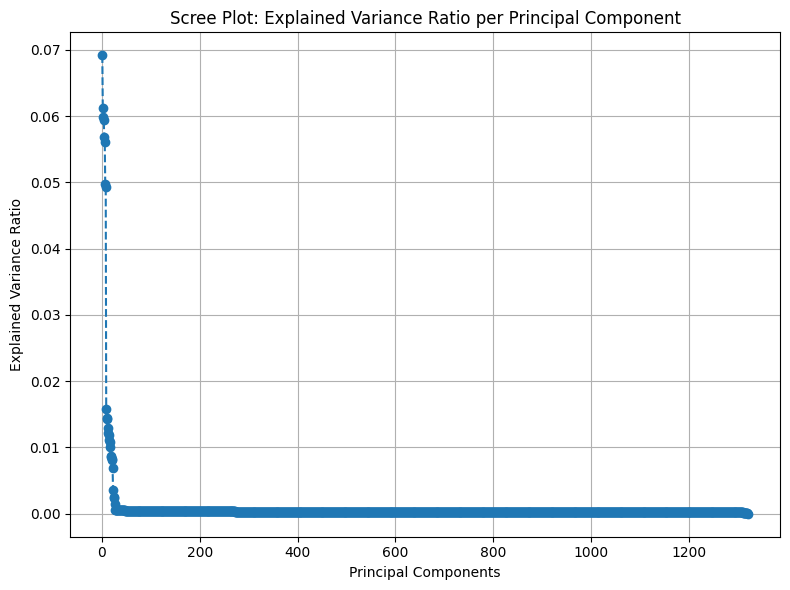

🏃 View run PCA_Dimensionality_Reduction at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0/runs/3ec043551ff045ebbeaf43f2cb6c3c07
🧪 View experiment at: https://dagshub.com/saisatvikh/final_repo.mlflow/#/experiments/0
Accuracy after PCA: 0.2879
Number of components selected: 1099


In [210]:
import pandas as pd
import numpy as np
import mlflow
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming df is your dataset and 'user_type' is the target column
target = 'user_type'

# Start MLflow run
mlflow.start_run(run_name="PCA_Dimensionality_Reduction")

# Split dataset into features and target
X = df.drop(columns=[target])
y = df[target]

# Log parameters
mlflow.log_param("target_column", target)

# Identify categorical and numerical columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(exclude=['object', 'category']).columns.tolist()

# Log categorical and numerical features
mlflow.log_param("categorical_features", categorical_features)
mlflow.log_param("numeric_features", numeric_features)

# Preprocessing pipeline for categorical and numerical features
numeric_transformer = StandardScaler()

# Convert categorical columns to string to avoid mixed types
X[categorical_features] = X[categorical_features].applymap(str)

# Categorical transformer for one-hot encoding with sparse_output=False (dense output)
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Apply preprocessing to the features
X_processed = preprocessor.fit_transform(X)

# Apply PCA for dimensionality reduction
pca = PCA()
X_pca = pca.fit_transform(X_processed)

# Log the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
mlflow.log_param("explained_variance_ratio", explained_variance_ratio.tolist())

# Create a scree plot to visualize the explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title("Scree Plot: Explained Variance Ratio per Principal Component")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.grid(True)
plt.tight_layout()

# Save the plot to a file
scree_plot_path = "scree_plot.png"
plt.savefig(scree_plot_path)

# Show the plot in the output
plt.show()

# Log the scree plot in MLFlow
mlflow.log_artifact(scree_plot_path)

# Determine how many components to keep based on cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)
mlflow.log_param("cumulative_variance", cumulative_variance.tolist())

# Log the number of components based on the desired explained variance threshold
threshold = 0.95  # Choose the threshold for explained variance
num_components = np.argmax(cumulative_variance >= threshold) + 1
mlflow.log_param("num_components_selected", num_components)

# Apply PCA with the selected number of components
pca_selected = PCA(n_components=num_components)
X_pca_selected = pca_selected.fit_transform(X_processed)

# Log results for the reduced dataset
mlflow.log_param("num_features_before_pca", X_processed.shape[1])
mlflow.log_param("num_features_after_pca", X_pca_selected.shape[1])

# Train and evaluate model on PCA-reduced features
def evaluate_model(X_selected, y):
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

accuracy_pca = evaluate_model(X_pca_selected, y)

# Log the model performance
mlflow.log_metric("accuracy_after_pca", accuracy_pca)

# End the MLflow run
mlflow.end_run()

# Print the results
print(f"Accuracy after PCA: {accuracy_pca:.4f}")
print(f"Number of components selected: {num_components}")


/var/folders/5q/38fn8x6x05j5m61tvnrj7t040000gn/T/ipykernel_1221/261019361.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-Score', y='Model', data=f1_df, palette='viridis')


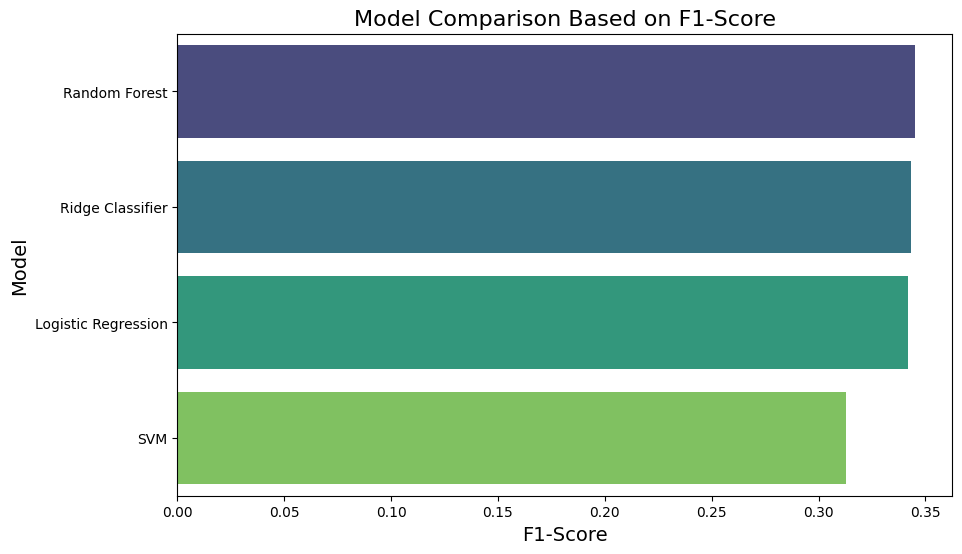

In [211]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns

model_names = ['Logistic Regression','Random Forest','Ridge Classifier','SVM']
f1_scores = [logistic_f1_score,random_forest_f1,ridge_f1_score,svm_f1_score]


f1_scores_df = pd.DataFrame({
    'Model': model_names,
    'F1-Score': f1_scores
})

f1_df = f1_scores_df.sort_values(by='F1-Score', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='F1-Score', y='Model', data=f1_df, palette='viridis')

plt.title('Model Comparison Based on F1-Score', fontsize=16)
plt.xlabel('F1-Score', fontsize=14)
plt.ylabel('Model', fontsize=14)

plt.show()